In [1]:
from swat import *
from pprint import pprint

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)


In [3]:
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.lr_scheduler import *
from dlpy.images import *
from dlpy.image_embedding import *

In [4]:
s = CAS('host_name', port_number)
s.sessionprop.setsessopt(caslib='CASUSER', timeout=31535000)
s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('datastep')

NOTE: 'CASUSER(userid)' is now the active caslib.
NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'datastep'.


[actionset]

 'datastep'

+ Elapsed: 0.000256s, user: 1.3e-05s, sys: 0.000222s, mem: 0.221mb

# Generate Image Embedding Table for Siamese Network

In [5]:
# load images from a given path on the CAS server side
# embedding_model_type defines the embedding table type that will be generated
# label_level defines how to generate the labels for images. 
# The images must be stored under different subdirectories. 
# -2 means using the first subdirectory name (1 level up from the image file name) as the label
# n_samples specifies how many image pairs will be generated
# resize_width and resize_height resize all the image pairs to the specified sizes
my_table= ImageEmbeddingTable.load_files(s, path='server_side_data_path', 
                                         embedding_model_type='siamese', label_level=-2, 
                                         n_samples=128, resize_width=224, resize_height=224)

In [6]:
# check how many image pairs are generated
my_table.numrows()

[numrows]

 128

+ Elapsed: 0.000214s, sys: 0.000199s, mem: 0.413mb

In [7]:
# check the columns in this table
my_table.columns

Index(['_id_', '_image_', '_size_', '_path_', '_type_', '_image_1', '_size_1',
       '_path_1', '_type_1', '_fName_', '_label_', '_fName_1', '_label_1',
       '_dissimilar_'],
      dtype='object')

In [8]:
# Note this returns the channel means from the first image column
my_table.channel_means

[107.4723926466338, 122.63439925836055, 130.1368141952826]

In [9]:
# Note this returns the image summary for the first image column
my_table.image_summary

jpg                   128
minWidth              224
maxWidth              224
minHeight             224
maxHeight             224
meanWidth             224
meanHeight            224
mean1stChannel    107.472
min1stChannel           0
max1stChannel         255
mean2ndChannel    122.634
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    130.137
min3rdChannel           0
max3rdChannel         255
dtype: object

In [10]:
# label_freq returns the label information for two image columns as well as the labels for image pairs
# it also returns the label information for the generated dissimilar column. 
# It has to be numerical and could be either 0 or 1. 0 means this image pair similar while 1 means it is not similar.
# This information is used as the target to train a Siamese Network model
label, label1, label_pair, dissimilar = my_table.label_freq

In [11]:
label

,Level,Frequency
german_shepherd,1,16
golden_retriever,2,21
labrador_retriever,3,31
miniature_poodle,4,34
soft-coated_wheaten_terrier,5,12
toy_poodle,6,14


In [12]:
label1

,Level,Frequency
german_shepherd,1,16
golden_retriever,2,21
labrador_retriever,3,31
miniature_poodle,4,34
soft-coated_wheaten_terrier,5,12
toy_poodle,6,14


In [13]:
label_pair

,Level,Frequency
"german_shepherd,german_shepherd",1,2
"german_shepherd,golden_retriever",2,2
"german_shepherd,labrador_retriever",3,6
"german_shepherd,miniature_poodle",4,1
"german_shepherd,soft-coated_wheaten_terrier",5,4
"german_shepherd,toy_poodle",6,1
"golden_retriever,german_shepherd",7,3
"golden_retriever,golden_retriever",8,4
"golden_retriever,labrador_retriever",9,6
"golden_retriever,miniature_poodle",10,7


In [14]:
dissimilar

,Level,Frequency
0,1,24
1,2,104


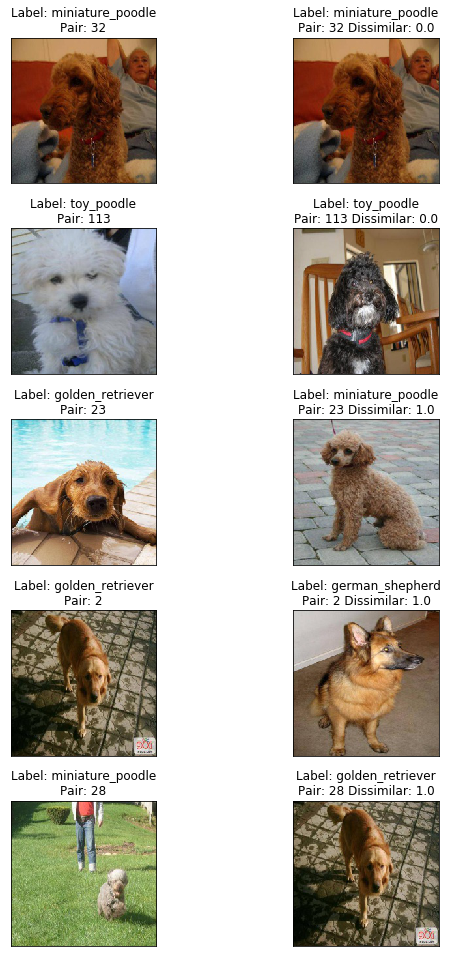

In [15]:
# display image pairs
my_table.show(n_image_pairs=5, randomize=True)

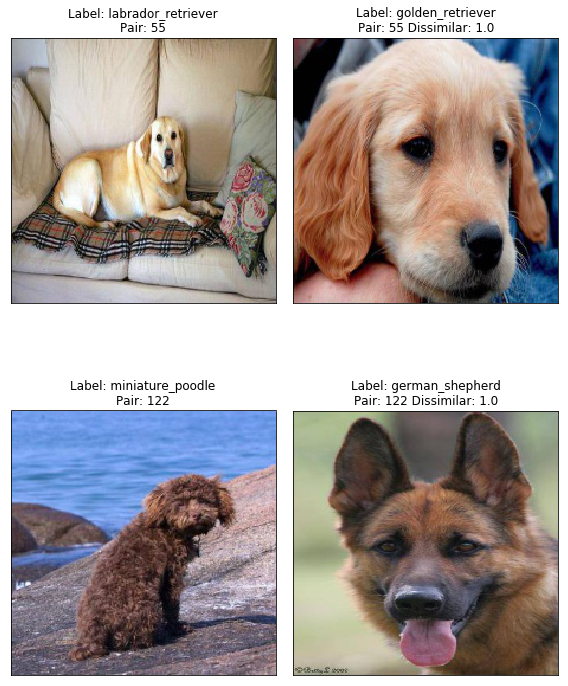

In [16]:
# user the whereclause to filter the display
my_table.show(n_image_pairs=2, randomize=True, where='_dissimilar_ = 1')

# Generate Image Embedding Table for Triplet Network

In [17]:
# To generate the data for training triplet network models, 
# only embedding_model_type needs changed to triplet.
# all other parameters have the same meaning as mentioned in Siamese Network
my_table_triplet = ImageEmbeddingTable.load_files(s, path='/cas/DeepLearn/dlpy/DogBreed_small', 
                                         embedding_model_type='triplet', label_level=-2, n_samples=128)

In [18]:
my_table_triplet.columns

Index(['_id_', '_image_', '_size_', '_path_', '_type_', '_image_1', '_size_1',
       '_path_1', '_type_1', '_image_2', '_size_2', '_path_2', '_type_2',
       '_fName_', '_label_', '_fName_1', '_label_1', '_fName_2', '_label_2'],
      dtype='object')

In [19]:
# The image triplet contains three label columns. label_freq can show the label information.
# Note the first image column (i.e., '_image_') contains the anchor images.
# The second image column (i.e., '_image_1') contains the postive images.
# The third image column (i.e., '_image_2') contains the negative images.
label, label1, label2, label_triplet = my_table_triplet.label_freq

In [20]:
label

,Level,Frequency
german_shepherd,1,20
golden_retriever,2,18
labrador_retriever,3,29
miniature_poodle,4,28
soft-coated_wheaten_terrier,5,17
toy_poodle,6,16


In [21]:
label_triplet

,Level,Frequency
"german_shepherd,german_shepherd,golden_retriever",1,3
"german_shepherd,german_shepherd,labrador_retriever",2,6
"german_shepherd,german_shepherd,miniature_poodle",3,4
"german_shepherd,german_shepherd,soft-coated_wheaten_terrier",4,3
"german_shepherd,german_shepherd,toy_poodle",5,4
"golden_retriever,golden_retriever,german_shepherd",6,4
"golden_retriever,golden_retriever,labrador_retriever",7,5
"golden_retriever,golden_retriever,miniature_poodle",8,4
"golden_retriever,golden_retriever,soft-coated_wheaten_terrier",9,3
"golden_retriever,golden_retriever,toy_poodle",10,2


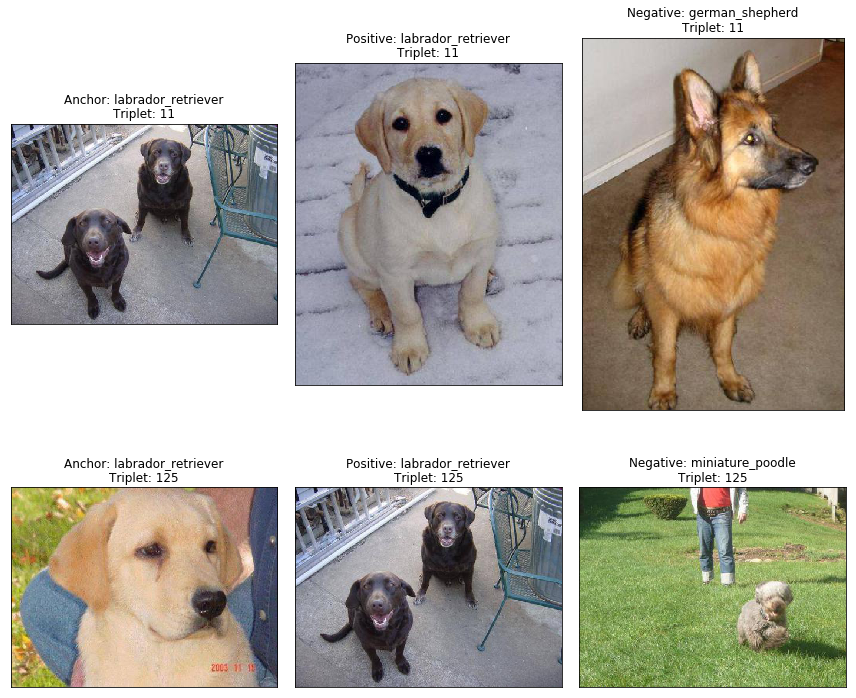

In [22]:
# display the image triplets
my_table_triplet.show(n_image_pairs=2, randomize=True)

# Generate Image Embedding Table for Quartet Network

In [23]:
# To generate the data for training quartet network models, 
# only embedding_model_type needs changed to quartet.
my_table_quartet = ImageEmbeddingTable.load_files(s, path='/cas/DeepLearn/dlpy/DogBreed_small', 
                                                  embedding_model_type='quartet', label_level=-2, 
                                                  n_samples=128, resize_width=224, resize_height=224)

In [24]:
my_table_quartet.columns

Index(['_id_', '_image_', '_size_', '_path_', '_type_', '_image_1', '_size_1',
       '_path_1', '_type_1', '_image_2', '_size_2', '_path_2', '_type_2',
       '_image_3', '_size_3', '_path_3', '_type_3', '_fName_', '_label_',
       '_fName_1', '_label_1', '_fName_2', '_label_2', '_fName_3', '_label_3'],
      dtype='object')

In [25]:
# a new column '_image_3' is generated besides the triplet to represent another negative sample
label, label1, label2, label3, label_quartet = my_table_quartet.label_freq

In [26]:
label3

,Level,Frequency
german_shepherd,1,23
golden_retriever,2,26
labrador_retriever,3,19
miniature_poodle,4,14
soft-coated_wheaten_terrier,5,21
toy_poodle,6,25


In [27]:
label_quartet

,Level,Frequency
"german_shepherd,german_shepherd,golden_retriever,golden_retriever",1,5
"german_shepherd,german_shepherd,labrador_retriever,labrador_retriever",2,7
"german_shepherd,german_shepherd,miniature_poodle,miniature_poodle",3,2
"german_shepherd,german_shepherd,soft-coated_wheaten_terrier,soft-coated_wheaten_terrier",4,3
"german_shepherd,german_shepherd,toy_poodle,toy_poodle",5,4
"golden_retriever,golden_retriever,german_shepherd,german_shepherd",6,5
"golden_retriever,golden_retriever,labrador_retriever,labrador_retriever",7,1
"golden_retriever,golden_retriever,soft-coated_wheaten_terrier,soft-coated_wheaten_terrier",8,5
"golden_retriever,golden_retriever,toy_poodle,toy_poodle",9,5
"labrador_retriever,labrador_retriever,german_shepherd,german_shepherd",10,4


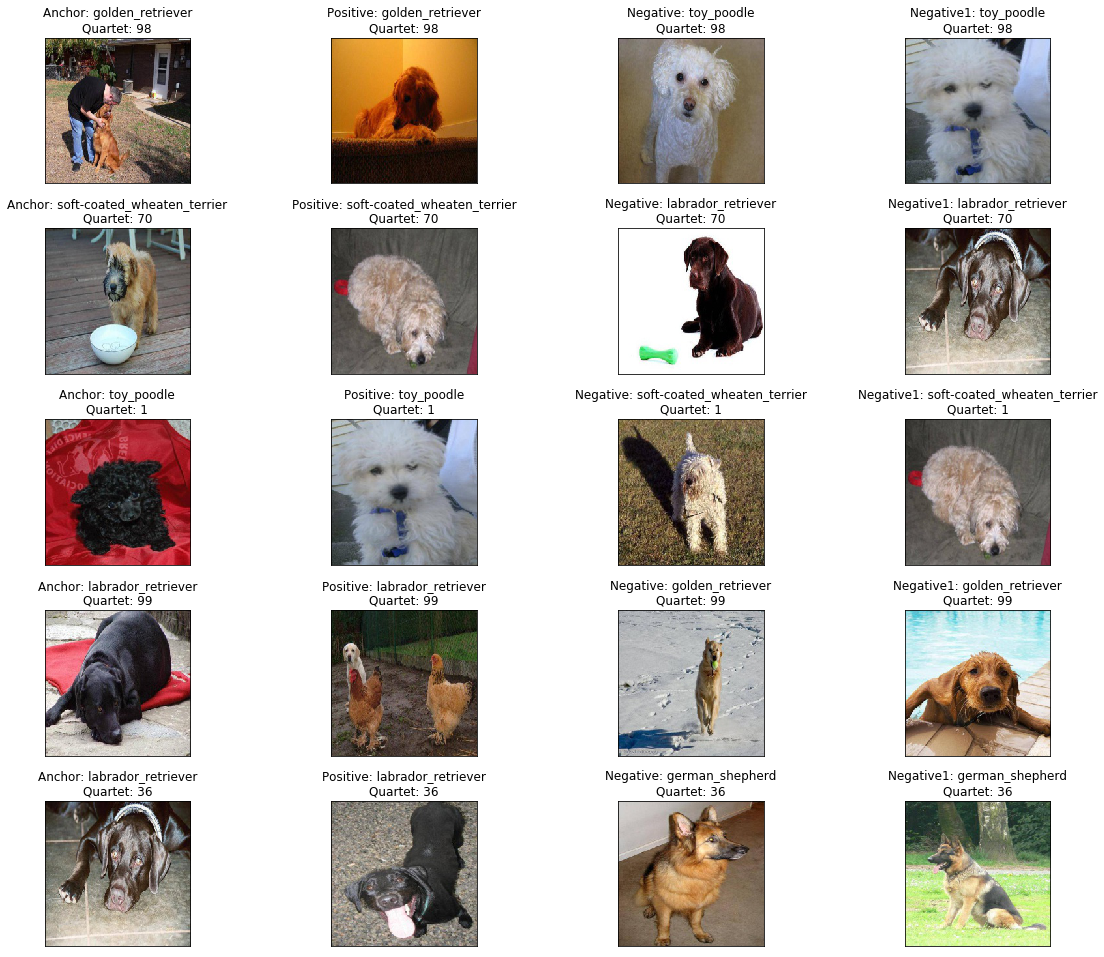

In [28]:
my_table_quartet.show()

In [29]:
# close the session
s.endsession()

+ Elapsed: 7.6e-05s, sys: 6.7e-05s, mem: 0.221mb